<a href="https://colab.research.google.com/github/minhvvan/DeepLearning/blob/main/BatchGradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [12]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=2, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self,x):
    z = np.dot(x, self.w) + self.b
    return z

  def backprop(self, x, err):
    m = len(x)
    w_grad = np.dot(x.T, err) / m   #가중치에 대한 평균 그레이디언트 계산
    b_grad = np.sum(err) / m    #절편에 대한 평균 그레이디언트 계산
    return w_grad, b_grad

  def activation(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1,1) #타겟을 열벡터로 변환
    y_val = y_val.reshape(-1,1) #val타겟을 열벡터로 변환
    m = len(x)
    self.w = np.ones((x.shape[1],1))  #가중치 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  #가중치 기록

    for i in range(epochs):
      z = self.forpass(x) #정방향 계산
      a = self.activation(z) #활성화 함수
      err = -(y - a)
      w_grad, b_grad = self.backprop(x,err)  #역방향 계산
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m  #그레이디언트 패널티적용
      self.w -= self.lr * w_grad  #가중치 업데이트
      self.b -= self.lr * b_grad  #절편 업데이트
      self.w_history.append(self.w.copy()) #가중치 기록
      a = np.clip(a, 1e-10,1-1e-10) #클리핑
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) #로그 손실과 규제 손실 적용
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)  #검증

  
  def predict(self, x):
    z = self.forpass(x)
    return z > 0

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10,1-1e-10) #클리핑
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1,1))

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)   #정방향 계산
    a = self.activation(z)  #활성화 함수
    a = np.clip(a, 1e-10,1-1e-10) #클리핑
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) #로그 손실, 규제 손실 더하여 기록


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [21]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val= y_val, epochs=10000)
single_layer.score(x_val_scaled,y_val)

0.967032967032967

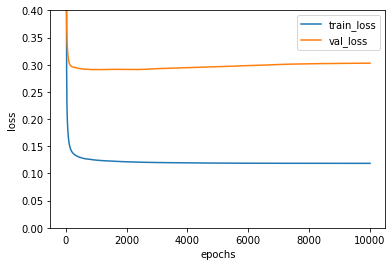

In [19]:
plt.ylim(0, 0.4)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

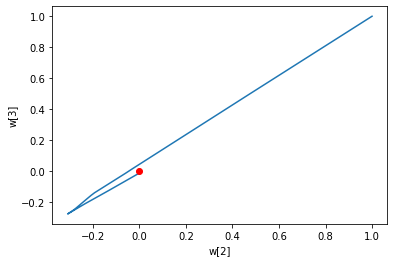

In [20]:
w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()